Dependencies:

In [47]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
from scipy.stats import norm

Performance metrics:

In [48]:
def calculate_performance_metrics(df):
    df['Daily Return'] = df['Portfolio Value'].pct_change().fillna(0)
    cumulative_return = df['Portfolio Value'].iloc[-1] / df['Portfolio Value'].iloc[0] - 1
    annualized_return = (1 + cumulative_return) ** (252 / len(df)) - 1
    sharpe_ratio = np.mean(df['Daily Return']) / np.std(df['Daily Return']) * np.sqrt(252)
    rolling_max = df['Portfolio Value'].cummax()
    drawdown = (df['Portfolio Value'] - rolling_max) / rolling_max
    max_drawdown = drawdown.min()
    win_rate = (df['Daily Return'] > 0).sum() / len(df['Daily Return'])
    
    return {
        'CAGR': annualized_return,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown,
        'Win Rate': win_rate,
        'Total Return': cumulative_return
    }

Fetch data from Yahoo finance:

In [49]:
# Fetch data
def fetch_data(ticker="AAPL", start="2018-01-01", end=None):
    end = end or datetime.today().strftime('%Y-%m-%d')
    return yf.download(ticker, start=start, end=end)

Plot a graph:

In [50]:
# Plot
def plot_performance(df, title="Strategy Performance"):
    df['Portfolio Value'].plot(figsize=(12, 6), title=title)
    plt.ylabel("Portfolio Value")
    plt.grid(True)
    plt.show()

## Strategy 1: Volatility Compression Breakout

In [51]:
# Signal Generation
def generate_volatility_compression_signals(df, bb_window, percentile, holding_period):
    df = df.copy()
    df['MA'] = df['Close'].rolling(window=bb_window).mean()
    df['STD'] = df['Close'].rolling(window=bb_window).std()
    df['Upper'] = df['MA'] + 2 * df['STD']
    df['Lower'] = df['MA'] - 2 * df['STD']
    df['Band Width'] = (df['Upper'] - df['Lower']) / df['MA']

    bandwidth_threshold = df['Band Width'].rolling(window=252).quantile(percentile)
    signals = (df['Band Width'] < bandwidth_threshold).astype(int)

    bandwidth_40th = df['Band Width'].rolling(window=252).quantile(0.40)
    position = [0] * len(signals)
    holding = 0
    for i in range(len(signals)):
        if holding > 0:
            position[i] = 1
            holding -= 1
            if df['Band Width'].iloc[i] > bandwidth_40th.iloc[i]:
                holding = 0  # exit early if expansion starts
        elif signals.iloc[i] == 1:
            holding = holding_period
            position[i] = 1

    return pd.Series(position, index=df.index, name="Signal")

Simple Backtest Strategy

In [52]:
# Simple backtest framework
def backtest_strategy(df, signals):
    if isinstance(signals, pd.DataFrame):
        signals = signals.iloc[:, 0]

    df = df.copy()
    df['Signal'] = signals

    position = df['Signal'].shift(1).fillna(0)
    if isinstance(position, pd.DataFrame):
        position = position.iloc[:, 0]

    df['Position'] = position

    price = df['Close']
    if isinstance(price, pd.DataFrame):
        price = price.iloc[:, 0]

    returns = price.pct_change().fillna(0)
    df['Strategy Return'] = position * returns
    df['Portfolio Value'] = (1 + df['Strategy Return']).cumprod()

    return df



Backtest with Risk Management Refinement Layer:

In [53]:
def backtest_with_risk_management(df, signals, stop_loss=0.03, take_profit=0.06, max_holding=5):
    df = df.copy()
    df['Signal'] = signals
    df['Position'] = 0
    df['Portfolio Value'] = 1.0

    in_trade = False
    entry_price = 0.0
    trade_days = 0

    for i in range(1, len(df)):
        current_close = df['Close'].iloc[i]
        if isinstance(current_close, pd.Series):
            current_close = current_close.iloc[0]  # Ensure scalar

        if df['Signal'].iloc[i] == 1 and not in_trade:
            in_trade = True
            entry_price = current_close
            df.at[df.index[i], 'Position'] = 1
        elif in_trade:
            price = current_close
            change = (price - entry_price) / entry_price

            if change <= -stop_loss or change >= take_profit or trade_days >= max_holding:
                in_trade = False
                trade_days = 0
            else:
                df.at[df.index[i], 'Position'] = 1
                trade_days += 1

    # Ensure both are Series (never accidentally DataFrames)
    close_series = df['Close']
    if isinstance(close_series, pd.DataFrame):
        close_series = close_series.iloc[:, 0]
    close_series = close_series.astype(float)

    position_series = df['Position']
    if isinstance(position_series, pd.DataFrame):
        position_series = position_series.iloc[:, 0]
    position_series = position_series.astype(float)

    returns = close_series.pct_change().fillna(0)
    df['Strategy Return'] = position_series.shift(1).fillna(0) * returns
    df['Portfolio Value'] = (1 + df['Strategy Return']).cumprod()

    return df


### Strategy 1 Feedback Loop AGI for Refinement

In [54]:
# Step 1: Fetch data
df = fetch_data("AAPL", start="2018-01-01")

[*********************100%***********************]  1 of 1 completed


Successful Experiment 2 suggested by the AGI:

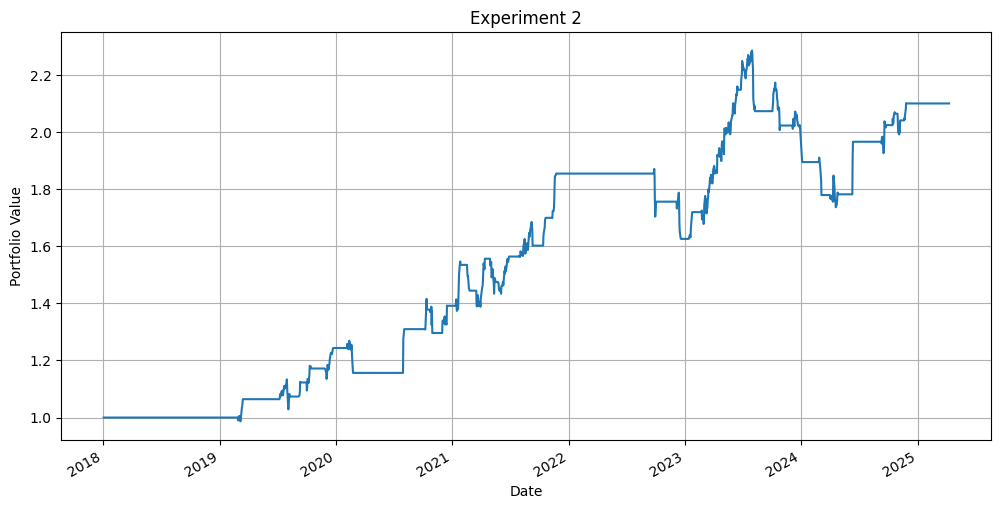

{'CAGR': np.float64(0.10764363212269057), 'Sharpe Ratio': np.float64(0.8693134226885613), 'Max Drawdown': np.float64(-0.24016242427581183), 'Win Rate': np.float64(0.13285948605795517), 'Total Return': np.float64(1.1001619249874803)}


In [55]:
signals = generate_volatility_compression_signals(df, bb_window=20, percentile=0.20, holding_period=5)
bt_df = backtest_strategy(df, signals)
metrics = calculate_performance_metrics(bt_df)
plot_performance(bt_df, title="Experiment 2")
print(metrics)

Experiment 2 Augumented with Risk Management:

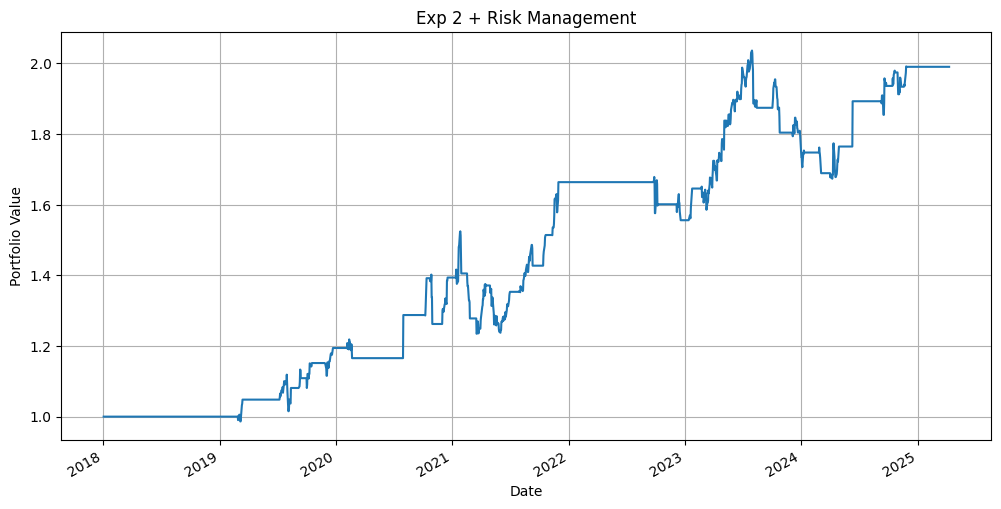

{'CAGR': np.float64(0.09946251521854066), 'Sharpe Ratio': np.float64(0.8180243388918489), 'Max Drawdown': np.float64(-0.1901565232233881), 'Win Rate': np.float64(0.1273920174958994), 'Total Return': np.float64(0.9901459456806452)}


In [56]:
signals = generate_volatility_compression_signals(df, bb_window=20, percentile=0.20, holding_period=5)
bt_df = backtest_with_risk_management(df, signals, stop_loss=0.03, take_profit=0.06)
metrics = calculate_performance_metrics(bt_df)
plot_performance(bt_df, title="Exp 2 + Risk Management")
print(metrics)

💾 Strategy 1 Summary
✅ Locked In Version:
Volatility Compression Breakout (V2)

BB Window: 20

Percentile: 20%

Holding: Up to 5 days

Stop-Loss: 3%

Take-Profit: 6%

## Strategy 2: Fear Factor Fade (VIX-based Contrarian)

Yahoo Finance Data Fetch:
- SPY (S&P 500 ETF) for price/returns
- ^VIX (CBOE Volatility Index) for sentiment

In [57]:
def fetch_vix_spy(start="2015-01-01", end=None):
    end = end or pd.Timestamp.today().strftime('%Y-%m-%d')
    spy = yf.download("SPY", start=start, end=end)['Close']
    spy.name = "SPY"
    vix = yf.download("^VIX", start=start, end=end)['Close']
    vix.name = "VIX"
    df = pd.concat([spy, vix], axis=1).dropna()
    return df

In [63]:
df = fetch_vix_spy()
df = df.rename(columns={"^VIX": "VIX"})
print(df.head())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Ticker             SPY        VIX
Date                             
2015-01-02  172.075226  17.790001
2015-01-05  168.967606  19.920000
2015-01-06  167.376083  21.120001
2015-01-07  169.461838  19.309999
2015-01-08  172.468872  17.010000


Signal Generation

In [64]:
def generate_vix_fade_v2_with_stop(df, vix_window=252, high_percentile=0.90, low_percentile=0.60, stop_loss=-0.035, max_hold=5):
    df = df.copy()
    df['VIX_high'] = df['VIX'].rolling(window=vix_window).quantile(high_percentile)
    df['VIX_low'] = df['VIX'].rolling(window=vix_window).quantile(low_percentile)
    df['SPY_ret'] = df['SPY'].pct_change().fillna(0)

    position = [0] * len(df)
    in_trade = False
    hold_days = 0
    entry_price = 0.0

    for i in range(1, len(df)):
        if not in_trade:
            if df['VIX'].iloc[i] > df['VIX_high'].iloc[i] and df['SPY_ret'].iloc[i] < 0:
                in_trade = True
                hold_days = 1
                entry_price = df['SPY'].iloc[i]
                position[i] = 1
        else:
            hold_days += 1
            current_price = df['SPY'].iloc[i]
            pnl = (current_price - entry_price) / entry_price
            position[i] = 1

            # Exit conditions: VIX calmed, max hold, or SPY dropped too much
            if (
                df['VIX'].iloc[i] < df['VIX_low'].iloc[i]
                or hold_days >= max_hold
                or pnl <= stop_loss
            ):
                in_trade = False
                hold_days = 0

    return pd.Series(position, index=df.index, name="Signal")


Simple backtest framework

In [65]:
def backtest_fear_fade(df, signals):
    df = df.copy()
    df['Signal'] = signals
    df['Position'] = df['Signal'].shift(1).fillna(0)
    df['Strategy Return'] = df['Position'] * df['SPY'].pct_change().fillna(0)
    df['Portfolio Value'] = (1 + df['Strategy Return']).cumprod()
    return df

### Strategy 2 Feedback Loop for AGI

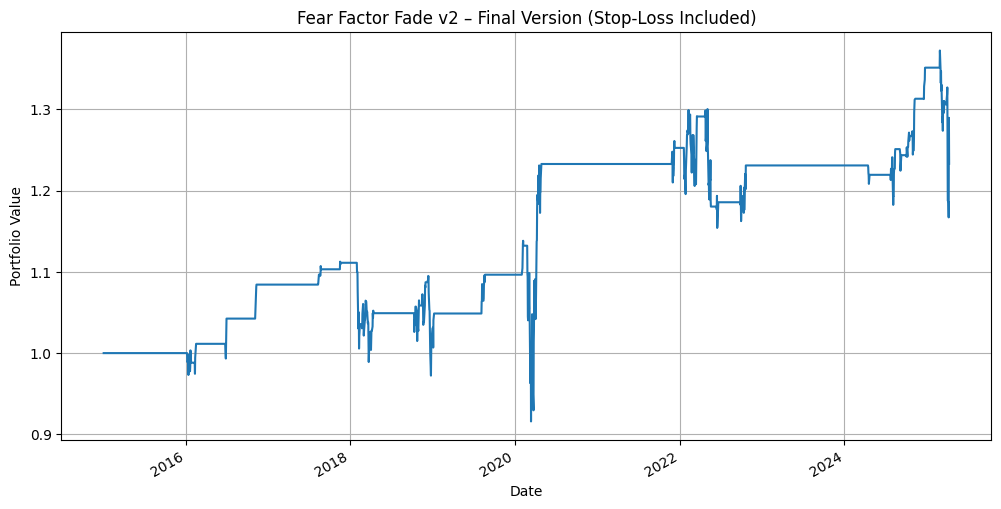

{'CAGR': np.float64(0.020645686046523615), 'Sharpe Ratio': np.float64(0.22980098678586627), 'Max Drawdown': np.float64(-0.19535206919884057), 'Win Rate': np.float64(0.0696594427244582), 'Total Return': np.float64(0.23311622507462704)}


In [66]:
signals = generate_vix_fade_v2_with_stop(df)
bt_df = backtest_fear_fade(df, signals)
metrics = calculate_performance_metrics(bt_df)
plot_performance(bt_df, title="Fear Factor Fade v2 – Final Version (Stop-Loss Included)")
print(metrics)

Final Thoughts on Strategy 2:
✅ Mean-reversion, fear-fade strategy

🧠 Logic grounded in sentiment + behavior

📉 Low-frequency, uncorrelated with breakout logic from Strategy 1

🔒 Stop-loss turned it from "clever but risky" to "viable allocation candidate"

## Strategy 3: Sentiment Mismatch Swing

Adding RSI to Dataframe

In [67]:
def add_rsi(df, period=14):
    delta = df['SPY'].diff()
    gain = delta.where(delta > 0, 0.0)
    loss = -delta.where(delta < 0, 0.0)

    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / avg_loss

    df['RSI'] = 100 - (100 / (1 + rs))
    return df


Detect Bullish Divergence Signals:

In [68]:
def generate_rsi_divergence_signals(df, lookback=10, holding=5):
    df = df.copy()
    df = add_rsi(df)

    signals = [0] * len(df)
    position = [0] * len(df)
    hold = 0

    for i in range(lookback, len(df)):
        price_now = df['SPY'].iloc[i]
        price_then = df['SPY'].iloc[i - lookback]
        rsi_now = df['RSI'].iloc[i]
        rsi_then = df['RSI'].iloc[i - lookback]

        # Bullish divergence: price down, RSI up
        if price_now < price_then and rsi_now > rsi_then and rsi_now < 50 and not hold:
            hold = holding
            signals[i] = 1

        if hold > 0:
            position[i] = 1
            hold -= 1

    return pd.Series(position, index=df.index, name="Signal")


Dual Divergence Signal

In [69]:
def generate_rsi_divergence_with_trend_filter(df, lookback=10, holding=5):
    df = df.copy()
    df = add_rsi(df)
    df['MA200'] = df['SPY'].rolling(window=200).mean()

    signals = [0] * len(df)
    position = [0] * len(df)
    hold = 0
    direction = 0  # 1 = long, -1 = short

    for i in range(lookback, len(df)):
        price_now = df['SPY'].iloc[i]
        price_then = df['SPY'].iloc[i - lookback]
        rsi_now = df['RSI'].iloc[i]
        rsi_then = df['RSI'].iloc[i - lookback]
        ma200 = df['MA200'].iloc[i]

        # Start new trade if not currently holding
        if hold == 0:
            # Bullish divergence: price down, RSI up, RSI < 50
            if price_now < price_then and rsi_now > rsi_then and rsi_now < 50:
                hold = holding
                direction = 1
                signals[i] = 1

            # Bearish divergence: price up, RSI down, RSI > 50 + SPY below MA200
            elif (
                price_now > price_then
                and rsi_now < rsi_then
                and rsi_now > 50
                and price_now < ma200  # ← trend filter for shorting
            ):
                hold = holding
                direction = -1
                signals[i] = -1

        else:
            signals[i] = direction
            hold -= 1

    return pd.Series(signals, index=df.index, name="Signal")


Dual-Sided Backtest Function

In [70]:
def backtest_dual_side(df, signals):
    df = df.copy()
    df['Signal'] = signals
    df['Position'] = df['Signal'].shift(1).fillna(0)
    df['Strategy Return'] = df['Position'] * df['SPY'].pct_change().fillna(0)
    df['Portfolio Value'] = (1 + df['Strategy Return']).cumprod()
    return df


### Strategy 3 Feedback Loop for AGI

Sentiment Mismatch Swing v1 – Bullish RSI Divergence

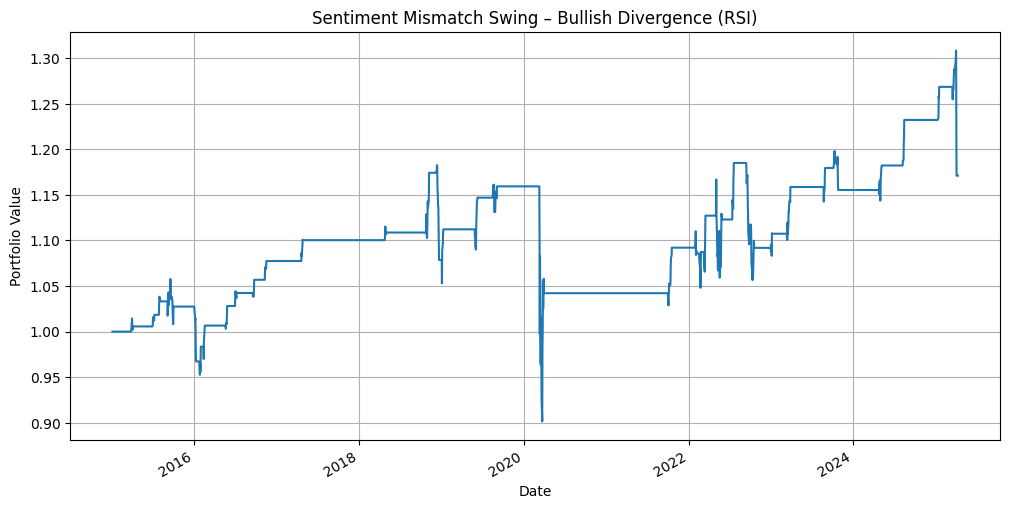

{'CAGR': np.float64(0.015524781278488442), 'Sharpe Ratio': np.float64(0.20771618268464004), 'Max Drawdown': np.float64(-0.23779350880357208), 'Win Rate': np.float64(0.05804953560371517), 'Total Return': np.float64(0.17112819902573495)}


In [71]:
signals = generate_rsi_divergence_signals(df)
bt_df = backtest_fear_fade(df, signals)  # we’re still just long/flat
metrics = calculate_performance_metrics(bt_df)
plot_performance(bt_df, title="Sentiment Mismatch Swing – Bullish Divergence (RSI)")
print(metrics)

Updated Signal Generator: Bullish + Filtered Bearish

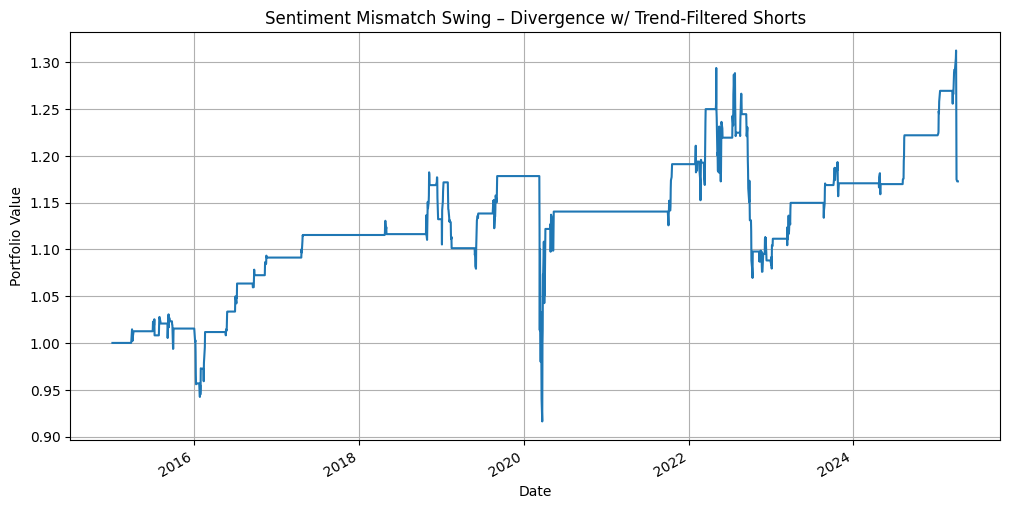

{'CAGR': np.float64(0.01564511312294936), 'Sharpe Ratio': np.float64(0.20221955728040053), 'Max Drawdown': np.float64(-0.22508207740839262), 'Win Rate': np.float64(0.07198142414860681), 'Total Return': np.float64(0.17255191898740696)}


In [72]:
signals = generate_rsi_divergence_with_trend_filter(df)
bt_df = backtest_dual_side(df, signals)
metrics = calculate_performance_metrics(bt_df)
plot_performance(bt_df, title="Sentiment Mismatch Swing – Divergence w/ Trend-Filtered Shorts")
print(metrics)

## Strategy 4: Rolling Reversal (Volatility-Weighted Pullback Entry)

Step 1: ATR + Trend Calculation

In [102]:
def add_trend_and_volatility(df, ma_period=50, atr_period=14):
    df = df.copy()
    df['MA'] = df['SPY'].rolling(window=ma_period).mean()

    high_low = df['SPY'].rolling(2).max() - df['SPY'].rolling(2).min()
    high_close = abs(df['SPY'] - df['SPY'].shift(1))
    tr = pd.concat([high_low, high_close], axis=1).max(axis=1)
    df['ATR'] = tr.rolling(atr_period).mean()

    return df

A refined v3 version with more realistic thresholds and risk management

In [ ]:
def generate_rolling_reversal_v3(df, ma_period=50, atr_period=14, atr_window=50,
                                 atr_thresh=0.5, holding=5, stop_loss=0.03):
    df = add_trend_and_volatility(df, ma_period, atr_period)

    df['ATR_Perc'] = df['ATR'].rolling(atr_window).apply(
        lambda x: (x.iloc[-1] - x.min()) / (x.max() - x.min()) if (x.max() - x.min()) > 0 else 1.0,
        raw=False
    )

    signals = [0] * len(df)
    hold = 0
    direction = 0
    entry_price = 0

    for i in range(ma_period, len(df)):
        price = df['SPY'].iloc[i]
        ma = df['MA'].iloc[i]
        atr_perc = df['ATR_Perc'].iloc[i]

        # If in trade, check stop-loss or continue
        if hold > 0:
            change = (price - entry_price) / entry_price * direction
            if change <= -stop_loss:
                hold = 0
                direction = 0
            else:
                signals[i] = direction
                hold -= 1
            continue

        # Only enter a new trade if not holding
        print(price, ma, atr_perc)
        if atr_perc <= atr_thresh:
            if price > ma and price < ma * 0.9997:  # Small pullback
                hold = holding
                direction = 1
                entry_price = price
                signals[i] = 1
                print(price,ma)
            elif price < ma and price > ma * 1.005:  # short entry
                hold = holding
                direction = -1
                entry_price = price
                signals[i] = -1

    return pd.Series(signals, index=df.index, name="Signal")


### Strategy 4 Feedback Loop for AGI

174.1944580078125 172.59524200439452 nan
176.28857421875 172.74166137695312 nan
175.48440551757812 172.90382781982422 nan
177.0334014892578 173.0552590942383 nan
176.6884307861328 173.13965026855467 nan
175.69561767578125 173.2318258666992 nan
173.12095642089844 173.29931365966797 nan
172.708740234375 173.36810546875 nan
173.1041717529297 173.46524475097655 nan
175.2159881591797 173.63544372558593 nan
173.68470764160156 173.73129333496092 nan
173.070556640625 173.80765716552733 nan
173.69309997558594 173.8793832397461 nan
174.86270141601562 173.92390899658204 0.5787814865840807
174.39987182617188 173.97810791015624 0.5752552940526346
174.98886108398438 174.03604553222655 0.48127430748093997
175.76287841796875 174.15486328125 0.479391638893494
176.7220916748047 174.33642211914062 0.4425652693378455
175.9228057861328 174.4710025024414 0.47093296899503984
176.25924682617188 174.65486389160156 0.4299487220529472
177.05026245117188 174.81316619873047 0.31857687023497155
176.99972534179688 1

C:\Users\spihc\AppData\Local\Temp\ipykernel_43164\1775408165.py:5: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = np.mean(df['Daily Return']) / np.std(df['Daily Return']) * np.sqrt(252)


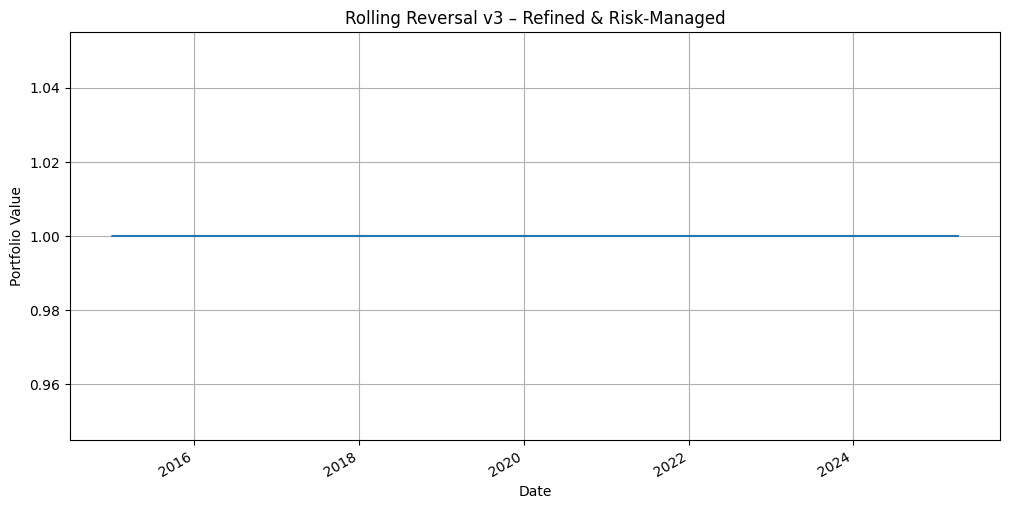

{'CAGR': np.float64(0.0), 'Sharpe Ratio': np.float64(nan), 'Max Drawdown': np.float64(0.0), 'Win Rate': np.float64(0.0), 'Total Return': np.float64(0.0)}


In [161]:
signals = generate_rolling_reversal_v3(df)
print("Signal distribution:\n", signals.value_counts())

bt_df = backtest_dual_side(df, signals)
metrics = calculate_performance_metrics(bt_df)
plot_performance(bt_df, title="Rolling Reversal v3 – Refined & Risk-Managed")
print(metrics)

In [162]:
signals = generate_rolling_reversal_v3(df, atr_thresh=1.0)
print("Signal distribution:\n", signals.value_counts())

174.1944580078125 172.59524200439452 nan
176.28857421875 172.74166137695312 nan
175.48440551757812 172.90382781982422 nan
177.0334014892578 173.0552590942383 nan
176.6884307861328 173.13965026855467 nan
175.69561767578125 173.2318258666992 nan
173.12095642089844 173.29931365966797 nan
172.708740234375 173.36810546875 nan
173.1041717529297 173.46524475097655 nan
175.2159881591797 173.63544372558593 nan
173.68470764160156 173.73129333496092 nan
173.070556640625 173.80765716552733 nan
173.69309997558594 173.8793832397461 nan
174.86270141601562 173.92390899658204 0.5787814865840807
174.39987182617188 173.97810791015624 0.5752552940526346
174.98886108398438 174.03604553222655 0.48127430748093997
175.76287841796875 174.15486328125 0.479391638893494
176.7220916748047 174.33642211914062 0.4425652693378455
175.9228057861328 174.4710025024414 0.47093296899503984
176.25924682617188 174.65486389160156 0.4299487220529472
177.05026245117188 174.81316619873047 0.31857687023497155
176.99972534179688 1